In [1]:
from stable_baselines3 import PPO, SAC, A2C, DDPG, DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
import time
import subprocess
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
subprocess.Popen('pip install -e .', shell=True)
print("things installed")
import os
import pickle
import csv
import numpy as np
import gym
from gym.envs.registration import register


register(
    id='gym_cell/cg-v0',
    entry_point='gym_cell.envs:CellEnv',
    max_episode_steps=10000,
)
print("enviornment registered")
time.sleep(3)







log_dir = './test_file'



eval_vec_env = gym.make('gym_cell/cg-v0')
eval_vec_env = Monitor(eval_vec_env,log_dir)



eval_callback = EvalCallback(eval_vec_env, best_model_save_path=log_dir,
                             log_path=log_dir, eval_freq=100,
                             deterministic=True, render=False, verbose=0, n_eval_episodes=11)


case_name = './strategy_base_case_test'
# model = PPO.load(case_name+"/best_model.zip", env=eval_vec_env)


model = PPO("MultiInputPolicy", eval_vec_env, seed = 89, verbose=0, tensorboard_log=log_dir)
model.learn(200, callback=[eval_callback], progress_bar=False)

print("finished!!!!")
print(model.policy)

things installed
enviornment registered


c:\Users\15156\anaconda3\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment gym_cell/cg-v0
  logger.warn("Overriding environment {}".format(id))


AttributeError: 'Box' object has no attribute 'spaces'

In [ ]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from typing import Callable, List, Optional, Tuple

import numpy as np
import pandas as pd

# import matplotlib
# matplotlib.use('TkAgg')  # Can change to 'Agg' for non-interactive mode
from matplotlib import pyplot as plt

from stable_baselines3.common.monitor import load_results

X_TIMESTEPS = "timesteps"
X_EPISODES = "episodes"
X_WALLTIME = "walltime_hrs"
POSSIBLE_X_AXES = [X_TIMESTEPS, X_EPISODES, X_WALLTIME]
EPISODES_WINDOW = 50


def rolling_window(array: np.ndarray, window: int) -> np.ndarray:
    """
    Apply a rolling window to a np.ndarray

    :param array: the input Array
    :param window: length of the rolling window
    :return: rolling window on the input array
    """
    shape = array.shape[:-1] + (array.shape[-1] - window + 1, window)
    strides = array.strides + (array.strides[-1],)
    return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)


def window_func(var_1: np.ndarray, var_2: np.ndarray, window: int, func: Callable) -> Tuple[np.ndarray, np.ndarray]:
    """
    Apply a function to the rolling window of 2 arrays

    :param var_1: variable 1
    :param var_2: variable 2
    :param window: length of the rolling window
    :param func: function to apply on the rolling window on variable 2 (such as np.mean)
    :return:  the rolling output with applied function
    """
    var_2_window = rolling_window(var_2, window)
    function_on_var2 = func(var_2_window, axis=-1)
    return var_1[window - 1 :], function_on_var2


def ts2xy(data_frame: pd.DataFrame, x_axis: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Decompose a data frame variable to x ans ys

    :param data_frame: the input data
    :param x_axis: the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :return: the x and y output
    """
    if x_axis == X_TIMESTEPS:
        x_var = np.cumsum(data_frame.l.values)
        y_var = data_frame.r.values
    elif x_axis == X_EPISODES:
        x_var = np.arange(len(data_frame))
        y_var = data_frame.r.values
    elif x_axis == X_WALLTIME:
        # Convert to hours
        x_var = data_frame.t.values / 3600.0
        y_var = data_frame.r.values
    else:
        raise NotImplementedError
    return x_var, y_var


def plot_curves(
    xy_list: List[Tuple[np.ndarray, np.ndarray]], x_axis: str, title: str, figsize: Tuple[int, int] = (5, 5)
) -> None:
    """
    plot the curves

    :param xy_list: the x and y coordinates to plot
    :param x_axis: the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param title: the title of the plot
    :param figsize: Size of the figure (width, height)
    """
    import pickle
    dict_ = {}

    plt.figure(title, figsize=figsize)
    max_x = max(xy[0][-1] for xy in xy_list)
    min_x = 0

    x_scatter_list = []
    y_scatter_list = []

    x_mean_list = []
    y_mean_list = []


    for (_, (x, y)) in enumerate(xy_list):
        # plt.scatter(x, y, s=7, alpha=.2)

        x_scatter_list.append(x)
        y_scatter_list.append(y)
        # Do not plot the smoothed curve at all if the timeseries is shorter than window size.
        if x.shape[0] >= EPISODES_WINDOW:
            # Compute and plot rolling mean with window of size EPISODE_WINDOW
            x, y_mean = window_func(x, y, EPISODES_WINDOW, np.mean)
            x_mean_list.append(x)
            y_mean_list.append(y_mean)
            plt.plot(x, y_mean)

    dict_['x_scatter'] = x_scatter_list
    dict_['y_scatter'] = y_scatter_list
    dict_['x_mean'] = x_mean_list
    dict_['y_mean'] = y_mean_list

    # print(dict_)

    with open(title +'.pkl',"wb") as f:

    # write the python object (dict) to pickle file
        pickle.dump(dict_,f)

    # close file
    f.close()






    plt.xlim(min_x, max_x)
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("Episode Rewards")
    plt.tight_layout()


def plot_results(
    dirs: List[str], num_timesteps: Optional[int], 
    x_axis: str, task_name: str, figsize: Tuple[int, int] = (5, 5)
) -> None:
    """
    Plot the results using csv files from ``Monitor`` wrapper.

    :param dirs: the save location of the results to plot
    :param num_timesteps: only plot the points below this value
    :param x_axis: the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param task_name: the title of the task to plot
    :param figsize: Size of the figure (width, height)
    """

    data_frames = []
    for folder in dirs:
        data_frame = load_results(folder)
        if num_timesteps is not None:
            data_frame = data_frame[data_frame.l.cumsum() <= num_timesteps]
        data_frames.append(data_frame)
    xy_list = [ts2xy(data_frame, x_axis) for data_frame in data_frames]
    plot_curves(xy_list, x_axis, task_name, figsize)

    
log_dir = './log_testing_1/'
# log_dir = './log_noise_level_3/'

timesteps = 1e6
plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "noise_base_case")
# plt.xlim([0,1000])
# plt.ylim([100,250])
# import pickle
# with open('noise_base_case' +'.pkl',"rb") as f:
#     c = pickle.load(f)

# plt.scatter(c['x_scatter'][0],c['y_scatter'][0], alpha=.2, s=5, color = 'b')
# plt.plot(c['x_mean'][0],c['y_mean'][0], color = 'b')
# plt.show()



In [ ]:
data_logging = {}

logs
mean size:  3179000


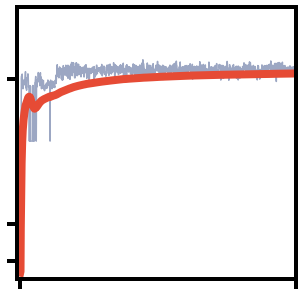

logs
mean size:  2468000


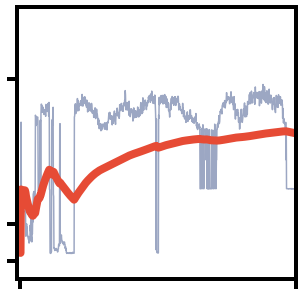

In [28]:
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from numpy import load

# name = './log_50timesteps_prev_reward_1M/evaluations.npz'
# name = './log_no_noise_hist_50timesteps_300k/evaluations.npz'
# name = './log_with_noise_hist_50timesteps_300k/evaluations.npz'
# name = './logs/log_PPO_3M/evaluations.npz'
name = './strategy_natex10_regen05/evaluations.npz'
# name = './strategy_regen05/evaluations.npz'

name = './strategy_ex100_conv45/evaluations.npz'
# name = './strategy_conv9natex10regen05ex25/evaluations.npz'
# name = './strategy_assymetric_conv9regen05exrate25/evaluations.npz'

# name = './strategy_base_case/evaluations.npz'
# name = './strategy_regen05_on_BaseCase/evaluations.npz'
# name = './strategy_assym_natex10regen05/evaluations.npz'

# name = './new_log_DQN_50step/evaluations.npz'
# name = './new_log_PPO_50step/evaluations.npz'
# name = './new_log_A2C_50step/evaluations.npz'

# name = './new_log_DQN_50step/evaluations.npz'
# name = './new_log_PPO_50step/evaluations.npz'
# name = './new_log_A2C_50step/evaluations.npz'

# name = './new_log_CNN_image_DQN_400step/evaluations.npz'

# name = './new_log_MultiInput_image_DQN_50step/evaluations.npz'

# name = './new_log_image_PPO_400step/evaluations.npz'

# name = './new_log_image_DQN_400step/evaluations.npz'


# names = ['./new_log_DQN_50step/evaluations.npz',
#          './new_log_PPO_50step/evaluations.npz',
#          './new_log_A2C_50step/evaluations.npz',
#          './new_log_CNN_image_DQN_400step/evaluations.npz',
#          './new_log_CNN_image_PPO_400step/evaluations.npz',
#          './new_log_CNN_image_A2C_400step/evaluations.npz',
#          './new_log_MultiInput_image_DQN_50step/evaluations.npz',
#          './new_log_MultiInput_image_PPO_50step/evaluations.npz',
#          './new_log_MultiInput_image_A2C_50step/evaluations.npz']

# names = ['./logs/log_PPO_2M_final/evaluations.npz',
#          './logs/log_PPO_ex100_conv45/evaluations.npz',
#          './logs/log_PPO_assym_ER_20_conv_09_natex5x_regen05/evaluations.npz',
#          './logs/log_PPO_natex5x_regen05/evaluations.npz']

names = ['./logs/log_50timesteps_prev_reward_1M/evaluations.npz',
             './logs/log_400timesteps_prev_rewardfactored_1M/evaluations.npz']


# name = './cross_ex100conv45_on_basecase/evaluations.npz'
# name = './cross_natex10regen05_on_basecase/evaluations.npz'
# name = './cross_not_assym_natex10regen05_on_basecase/evaluations.npz'
# name = './cross_base_case/evaluations.npz'




# name = './logs/log_400timesteps_prev_rewardfactored_1M/evaluations.npz'
name = './logs/log_50timesteps_prev_reward_1M/evaluations.npz'
# name = './logs/log_PPO_2M_final/evaluations.npz'
# name = './log_hist_50timesteps_300k/evaluations.npz'


for name in names:
    print(name.split('/')[1])
    data = load(name)

    x =  data['timesteps']

    mean_1 = []
    std_1 = []


    range_ = data['results'].shape[0]
    # range_ = 500

    for i in range(range_):
        # print(data['results'][i],np.median(data['results'][i]),np.std(data['results'][i]))
        mean_1.append(np.median(data['results'][i]))
        std_1.append(np.std(data['results'][i]))


    avg_median = []
    avg_std = []

    for i in range(len(mean_1)):
        avg_median.append(sum(mean_1[:(i+1)])/(len(mean_1[:(i+1)])))
        avg_std.append(sum(std_1[:(i+1)])/(len(std_1[:(i+1)])))


    width = 4

    mean_1 = np.array(mean_1)
    std_1 = np.array(std_1)

    avg_median = np.array(avg_median)
    avg_std = np.array(avg_std)

    plt.figure(figsize=(5,5))


    # dict_ = {}
    # dict_['x'] = x[:range_]
    # dict_['y'] = mean_1
    # data_logging['assym'] = dict_


    # plt.plot(x[:range_], mean_1, color ='#8491B4FF',  label='episodic reward',alpha = .8)
    # # plt.fill_between(x, mean_1 - std_1, mean_1 + std_1, color='#8491B4FF', alpha=0.2)


    plt.plot(x[:range_], mean_1, color = '#8491B4FF',  label='episodic reward',alpha = .8)
    # # plt.fill_between(x, mean_1 - std_1, mean_1 + std_1, color='#8491B4FF', alpha=0.2)

    plt.plot(x[:range_], avg_median, color = '#E64B35FF', linewidth = 8,label='average episodic reward')
    # # plt.fill_between(x, avg_median - avg_std, avg_median + avg_std, color='#E64B35FF', alpha=0.2)

    print("mean size: ",x[:range_][-1])


    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])



    ax.spines["bottom"].set_linewidth(width)
    ax.spines["top"].set_linewidth(width)
    ax.spines["left"].set_linewidth(width)
    ax.spines["right"].set_linewidth(width)
    ax.xaxis.set_tick_params(length=10,  width=width)
    ax.yaxis.set_tick_params(length=10, width=width)


    # plt.fill_between(x, avg_median-avg_std, avg_median+avg_std, color='r', alpha=0.2)
    x_lim = 1e6

    plt.xlim([-10000,x_lim])
    plt.ylim([-150,600])
    plt.xticks([0,x_lim])
    plt.yticks([-100,0,400])
    # plt.title(name.split('/')[1])
    # plt.legend(title='title')

    # plt.savefig('test.png', transparent = True)
    plt.show()


In [ ]:
for i in data_logging.keys():
    print(i)

In [ ]:
import pickle

# create a dictionary using {}

print('dictionary')
print(data_logging)

# save dictionary to person_data.pkl file
with open('cross_testing.pkl', 'wb') as fp:
    pickle.dump(data_logging, fp)
    print('dictionary saved successfully to file')

In [ ]:
import pickle
with open('./log_testing_1/timestep_vs_avg_reward' +'.pkl',"rb") as f:
    c = pickle.load(f)

# plt.scatter(c['x_scatter'][0],c['y_scatter'][0], alpha=.2, s=5, color = 'b')
# plt.plot(c['x_mean'][0],c['y_mean'][0], color = 'b')
# plt.show()
print(c)

In [ ]:
from stable_baselines3 import PPO
import gym
from gym.envs.registration import register
import time
import csv


register(
    id='gym_cell/cg-v0',
    entry_point='gym_cell.envs:CellEnv',
    max_episode_steps=30,
)

case_name = "log_noise_level_3_1M"

time.sleep(3)
env = gym.make('gym_cell/cg-v0')
model = PPO.load(case_name+"/best_model.zip", env=env)
# Enjoy trained agent
vec_env = model.get_env()
obs = vec_env.reset()


reward_main_list = []
for i in range(1000):
    obs = vec_env.reset()
    reward_list = []
    action_list = []
    for count,i in enumerate([i+1 for i in range(20)]):
        action, _states = model.predict(obs, deterministic=True)
        # bead_dict['step num '+str(count+1)] = action[0]
        obs, rewards, dones, info = vec_env.step(action)
        reward_list.append(rewards[0])
        action_list.append(action[0])
        if dones:
            # print(action_list, sum(reward_list))
            reward_main_list.append(sum(reward_list))
            reward_list = []

In [ ]:
np.linspace(-100,500,num=13)

In [ ]:
import numpy as np
from IPython import display
# data1  = np.load('./log_without_noise/evaluations.npz')
data2  = np.load('./log_with_noise_hist_50timesteps_300k/1000_runs_dir/evaluations.npz')
print(data2['results'].shape)


import matplotlib.pyplot as plt



# plt.figure(figsize=(8,2))


import seaborn as sns
for i in range(data2['results'].shape[0]):
    if i % 50 == 0 or i==0 or i ==1:
        print("value of i:",i)
        # plt.clf()    
        # display.clear_output(wait=True)
        # display.display(plt.gcf()) 
        
        plt.figure(figsize=(4,8))
        ax = plt.gca()

        width = 4

        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.spines["bottom"].set_linewidth(0)
        ax.spines["top"].set_linewidth(0)
        ax.spines["left"].set_linewidth(width)
        ax.spines["right"].set_linewidth(0)
        ax.xaxis.set_tick_params(length=10,  width=width)
        ax.yaxis.set_tick_params(length=10, width=width)
        ax.xaxis.set_ticks_position('both')
        # twin_ax = ax.twinx()
        # twin_ax.set_xticks([100])
        plt.xlim([0,450])
        plt.ylim([-100,450])
        plt.xticks([])
        plt.yticks([-70,0,100,200,300,400])
        # for i in range(data['results'].shape[0]):

# plt.hist(np.array(data1['results'][0]), bins=100, orientation='horizontal',alpha=.5) '#1f77b4''#1f77b4'
        plt.hist(np.array(data2['results'][i]), bins=np.linspace(-100,500,num=49), orientation='horizontal',color = '#ff7f0e')
        plt.show()
        # plt.close()
        # plt.pause(.1)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import load

# name = './log_50timesteps_prev_reward_1M/evaluations.npz'
name = './log_no_noise_hist_50timesteps_300k/evaluations.npz'
name2 = './log_with_noise_hist_50timesteps_300k/evaluations.npz'



data = load(name)
data2 = load(name2)

x =  data['timesteps']
x2 =  data2['timesteps']


mean_1 = []
std_1 = []

mean_2 = []
std_2 = []


range_ = data['results'].shape[0]
range_2 = data2['results'].shape[0]

for i in range(range_2):
    # print(data['results'][i],np.median(data['results'][i]),np.std(data['results'][i]))
    mean_2.append(np.median(data2['results'][i]))
    std_2.append(np.std(data2['results'][i]))



for i in range(range_):
    # print(data['results'][i],np.median(data['results'][i]),np.std(data['results'][i]))
    mean_1.append(np.median(data['results'][i]))
    std_1.append(np.std(data['results'][i]))


avg_median = []
avg_std = []
avg_median2 = []
avg_std2 = []

for i in range(len(mean_1)):
    avg_median.append(sum(mean_1[:(i+1)])/(len(mean_1[:(i+1)])))
    avg_std.append(sum(std_1[:(i+1)])/(len(std_1[:(i+1)])))


for i in range(len(mean_2)):
    avg_median2.append(sum(mean_2[:(i+1)])/(len(mean_2[:(i+1)])))
    avg_std2.append(sum(std_2[:(i+1)])/(len(std_2[:(i+1)])))




width = 4

mean_1 = np.array(mean_1)
std_1 = np.array(std_1)

avg_median = np.array(avg_median)
avg_std = np.array(avg_std)


mean_2 = np.array(mean_2)
std_2= np.array(std_2)

avg_median2 = np.array(avg_median2)
avg_std2 = np.array(avg_std2)


plt.plot(x[:range_], mean_1, color = '#1f77b4',  label='episodic reward',alpha = .5)
# plt.fill_between(x, mean_1 - std_1, mean_1 + std_1, color='#8491B4FF', alpha=0.2)

plt.plot(x[:range_], avg_median, color = '#1f77b4', linewidth = 4,label='average episodic reward',alpha = .8)
# plt.fill_between(x, avg_median - avg_std, avg_median + avg_std, color='#E64B35FF', alpha=0.2)

plt.plot(x2[:range_2], mean_2, color = '#ff7f0e',  label='episodic reward',alpha = .5)
# plt.fill_between(x, mean_1 - std_1, mean_1 + std_1, color='#8491B4FF', alpha=0.2)

plt.plot(x2[:range_2], avg_median2, color = '#ff7f0e', linewidth = 4,label='average episodic reward',alpha = .8)
# plt.fill_between(x, avg_median - avg_std, avg_median + avg_std, color='#E64B35FF', alpha=0.2)


print("mean size x1: ",x[:range_][-1])
print("mean size x2: ",x[:range_][-1])

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])



ax.spines["bottom"].set_linewidth(width)
ax.spines["top"].set_linewidth(0)
ax.spines["left"].set_linewidth(width)
ax.spines["right"].set_linewidth(0)
ax.xaxis.set_tick_params(length=10,  width=width)
ax.yaxis.set_tick_params(length=10, width=width)


# plt.fill_between(x, avg_median-avg_std, avg_median+avg_std, color='r', alpha=0.2)
x_lim = .545e6

plt.xlim([-10000,x_lim])
plt.ylim([-80,320])
plt.xticks([0,.25e6,.5e6])
plt.yticks([-50,0,300])
# plt.title(name.split('/')[1])
# plt.legend(title='title')
plt.show()